# Hierarchical Models

In [1]:
import collections
import itertools

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc3 as pm
import pandas as pd

import mcmc_utils

# Exercise 1

Therapoetic touch data with different priors

### Question A + B

Compare vague gamma distributed priors with different parameters.

In [2]:
# Calculations are based on info from wikipedia
# http://en.wikipedia.org/wiki/Gamma_distribution

GammaParams = collections.namedtuple('GammaParams', ['shape', 'scale'])


def gamma_params_from_mean_and_sd(mean, sd):
    return GammaParams((mean / sd) ** 2, sd ** 2 / mean)


def gamma_params_from_mode_and_sd(mode, sd):
    scale = ((mode ** 2 + 4 * sd ** 2) ** 0.5 - mode) / 2
    shape = (sd / scale) ** 2
    return GammaParams(shape, scale)


def plot_gammas(*gamma_params_list, extra_labels=(), max_x=200):
    x = np.linspace(0, max_x, 200)
    for gamma_params, extra_label in itertools.zip_longest(gamma_params_list, extra_labels):
        text = r'$k = {:.2f}$; $\theta = {:.2f}$'.format(gamma_params.shape, gamma_params.scale)
        if extra_label:
            text = '{}: {}'.format(extra_label, text)
        plt.plot(x, stats.gamma(gamma_params.shape, scale=gamma_params.scale).pdf(x), label=text)

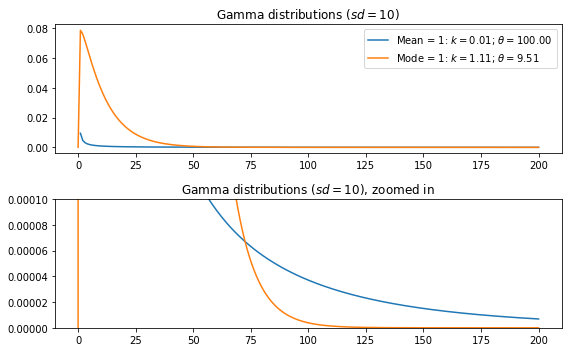

In [3]:
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
gammas = (gamma_params_from_mean_and_sd(1, 10), gamma_params_from_mode_and_sd(1, 10))
plot_gammas(*gammas, extra_labels=('Mean = 1', 'Mode = 1'))
title = 'Gamma distributions $(sd = 10)$'
plt.legend()
plt.title(title)

plt.subplot(2, 1, 2)
plot_gammas(*gammas)
plt.ylim((0, .0001))
plt.title(title + ', zoomed in')
plt.tight_layout()

The gamma distribution with mode = 1 favors values between 0.1 and 75.

The gamma distribution with mean = 1 favors very small values or those larger than 75.

### Question C

Notice how the different priors above cause similar posteriors.

In [4]:
TRACE_LENGTH = 10000

data = pd.read_csv('data/therapeutic_touch_data.csv')
subjects_data = [data[data.s == subject].y.values for subject in data.s.unique()]

In [5]:
def run_model_with_gamma_params(gamma_params, subjects=None, data=None):
    
    assert subjects or data, 'Supply at least one of [subjects, data]'
    if data:
        subjects = len(data)
    
    with pm.Model():
        
        # Priors
        omega = pm.Beta('omega', 1, 1)
        # PyMC3 works with rate parameter instead of scale parameter
        kappa = pm.Gamma('kappa', gamma_params.shape, 1 / gamma_params.scale) + 2

        # Model hierarchies
        beta_a = omega * (kappa - 2) + 1
        beta_b = (1 - omega) * (kappa - 2) + 1
        subject_theta = pm.Beta('theta', beta_a, beta_b, shape=(subjects, 1))
        if data:
            pm.Bernoulli('y', subject_theta, observed=data)

        # Inference
        start = pm.find_MAP()
        # Metropolis sample the prior faster
        sampler = pm.NUTS(scaling=start) if data else pm.Metropolis()
        trace = pm.sample(TRACE_LENGTH, sampler, start=start)

    return trace

In [6]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
mean_1_trace = run_model_with_gamma_params(gamma_params, data=subjects_data)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa, omega]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [7]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
mode_1_trace = run_model_with_gamma_params(gamma_params, data=subjects_data)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa, omega]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [8]:
mean_1_omega = mean_1_trace.get_values('omega')
mode_1_omega = mode_1_trace.get_values('omega')

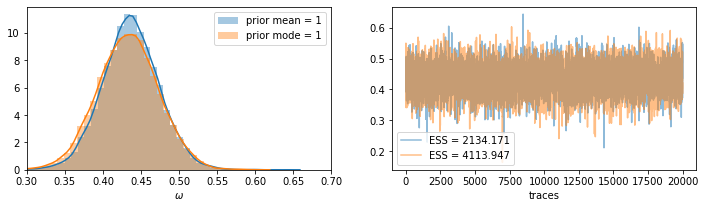

In [9]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.distplot(mean_1_omega, label='prior mean = 1')
sns.distplot(mode_1_omega, label='prior mode = 1')
plt.xlim((0.3, 0.7))
plt.xlabel(r'$\omega$')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(mean_1_omega, label='ESS = {:.3f}'.format(mcmc_utils.ess(mean_1_omega)), alpha=.5)
plt.plot(mode_1_omega, label='ESS = {:.3f}'.format(mcmc_utils.ess(mode_1_omega)), alpha=.5)
plt.xlabel('traces')
_ = plt.legend()

Notice that the low ESS are due to omega being a high level variable. Comparing to subject's theta:

In [10]:
subject_theta = [x.item(6) for x in mean_1_trace.get_values('theta')]
print(mcmc_utils.ess(subject_theta))

8247.07948369999


### Question D

There is a minor difference in the posterior due to the change in the prior, although it is much less significant than expected.

Question: "For which prior does the nargubak oisterior distribution on k have a bigger large-value tail?"

Didn't find a big difference in the large-value tail, as the author suggest.

Question: "When k is larger, what effect does that have on shrinkage of the thetas values?"

In [11]:
def plot_shrinkage_comparison(traces):
    '''
    traces is a list of (trace, label, color) tuples.
    '''
    plt.figure(figsize=(6, 2))
    for i, (trace, label, color) in enumerate(traces):
        thetas = trace.get_values('theta')
        ones = np.ones(thetas.shape[1])
        means = thetas.reshape(thetas.shape[:-1]).mean(axis=0)
        plt.bar(means, height=((-1) ** i) * ones, width=0.005, alpha=.3, linewidth=0,
                color=color, label=label)
    plt.xlim((.3, .6))
    plt.yticks((), ())
    plt.legend()
    plt.xlabel(r'$\theta$')

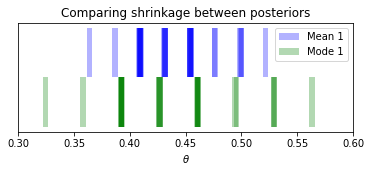

In [12]:
plot_shrinkage_comparison(((mean_1_trace, 'Mean 1', 'blue'), (mode_1_trace, 'Mode 1', 'green')))
_ = plt.title('Comparing shrinkage between posteriors')

It is obvious from omega histogram that mode == 1 presents a broader distribution. The above strengthen this observation with the exact shrinkage of the thetas, presenting much more shrinkage when the mean is 1.

# Exercise 2

Examine the same priors again, using MCMC to gain insights about the prior shrinkage.

In [13]:
TRACE_LENGTH = 100000
gamma_params = gamma_params_from_mean_and_sd(1, 10)
mean_1_prior = run_model_with_gamma_params(gamma_params, subjects=28)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [kappa]
>Metropolis: [omega]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 64 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
mode_1_prior = run_model_with_gamma_params(gamma_params, subjects=28)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [kappa]
>Metropolis: [omega]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


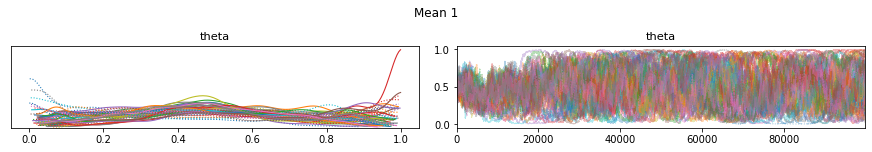

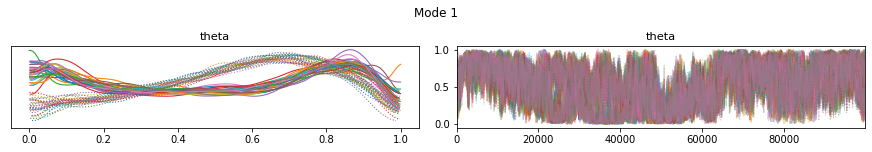

In [15]:
pm.traceplot(mean_1_prior, var_names=['theta'])
plt.gcf().suptitle('Mean 1')
fig = pm.traceplot(mode_1_prior, var_names=['theta'])
plt.gcf().suptitle('Mode 1');

### Question A + B

The mode 1 prior result in much rounded thetas because kappa is concentrated around low values (compared to mean 1 prior), hence the thetas are less broad.

If the priors should be vague as possible mean 1 prior is probably better.